<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Dayana Navarro Valencia y Juan Pablo Ruiz Magaña

**Fecha:** 7 de mayo del 2021

**Expediente** : if721470
**Profesor:** Oscar David Jaramillo Zuluaga.

## Link de Github: https://github.com/DayanaNavarro/Tarea-11

# Tarea 11: Clase 24

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

# RESPUESTA DAYANA

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# ACTIVO MC´DONALS

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['MCD'], '2017-01-01')
closes_mc = closes.loc[:,'MCD']
closes_mc.head()

Date
2017-01-03    107.688629
2017-01-04    107.562599
2017-01-05    107.760643
2017-01-06    108.714912
2017-01-09    108.417847
Name: MCD, dtype: float64

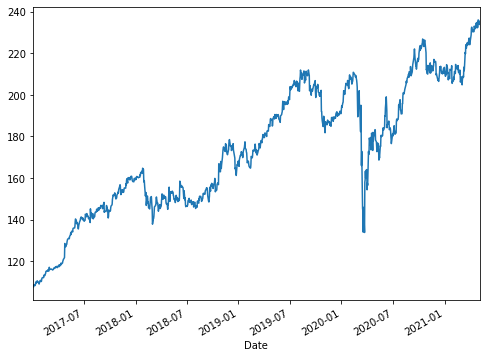

In [5]:
closes_mc.plot(figsize=(8,6));

In [6]:
closes_mc[-1]

235.0399932861328

## Calculamos rendimientos

In [7]:
ret_mc = calc_daily_ret(closes_mc)

## Descargamos datos de opciones para poder valuarlos

In [8]:
pd.set_option('display.max_rows', 10)

mc = web.YahooOptions('MCD')
mc_opt = mc.get_all_data().reset_index()
mc_opt.set_index('Expiry').sort_index()#.head(1000)

,Strike,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,,,,,,,,,,,,
2021-05-07,217.5,call,MCD210507C00217500,17.80,16.25,18.90,0.00,0.000000,5.0,8.0,0.834963,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-30 17:18:23,"{'contractSymbol': 'MCD210507C00217500', 'stri..."
2021-05-07,230.0,call,MCD210507C00230000,4.58,4.85,5.60,0.11,2.460853,50.0,445.0,0.265144,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 17:16:51,"{'contractSymbol': 'MCD210507C00230000', 'stri..."
2021-05-07,230.0,put,MCD210507P00230000,0.23,0.21,0.27,-0.25,-52.083332,278.0,921.0,0.207527,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:34:19,"{'contractSymbol': 'MCD210507P00230000', 'stri..."
2021-05-07,232.5,call,MCD210507C00232500,3.09,2.79,3.10,0.91,41.743110,476.0,555.0,0.177498,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:22:49,"{'contractSymbol': 'MCD210507C00232500', 'stri..."
2021-05-07,232.5,put,MCD210507P00232500,0.55,0.45,0.54,-0.43,-43.877552,280.0,394.0,0.174325,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:27:40,"{'contractSymbol': 'MCD210507P00232500', 'stri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20,145.0,call,MCD230120C00145000,80.80,86.15,89.40,0.00,0.000000,1.0,4.0,0.000010,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-03-17 18:46:10,"{'contractSymbol': 'MCD230120C00145000', 'stri..."
2023-01-20,145.0,put,MCD230120P00145000,3.73,2.92,4.15,0.00,0.000000,4.0,133.0,0.308265,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-29 14:29:48,"{'contractSymbol': 'MCD230120P00145000', 'stri..."
2023-01-20,150.0,call,MCD230120C00150000,85.18,82.50,87.50,0.00,0.000000,1.0,41.0,0.251625,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-30 17:19:31,"{'contractSymbol': 'MCD230120C00150000', 'stri..."


## Volatility smile 

In [44]:
fecha = '2021-05-15'
call_f1 = mc_opt.loc[(mc_opt.Expiry== fecha1) & (mc_opt.Type=='call')]


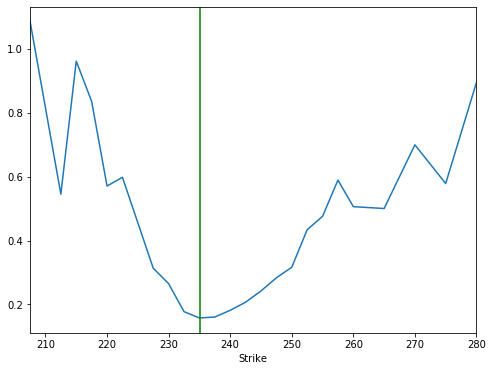

In [38]:
# Para los call de la fecha 1
ax = call_f1.set_index('Strike').loc[:, 'IV'].plot(figsize=(8,6))
ax.axvline(call_f1.Underlying_Price.iloc[0], color='g');

In [46]:
opt_deseada = mc_opt.loc[(mc_opt.Type=='call') & (mc_opt.Strike==230) & (mc_opt.Expiry=='2021-05-07')]
opt_deseada

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
369,230.0,2021-05-07,call,MCD210507C00230000,4.58,4.85,5.6,0.11,2.460853,50.0,445.0,0.265144,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 17:16:51,"{'contractSymbol': 'MCD210507C00230000', 'stri..."


In [47]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            230
Expiry                                            2021-05-07 00:00:00
Type                                                             call
Symbol                                             MCD210507C00230000
Last                                                             4.58
                                          ...                        
Underlying                                                        MCD
Underlying_Price                                               235.04
Quote_Time                                        2021-05-05 20:00:02
Last_Trade_Date                                   2021-05-05 17:16:51
JSON                {'contractSymbol': 'MCD210507C00230000', 'stri...
Name: 369, Length: 19, dtype: object

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [48]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = (0.06/100) / 360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666665e-06)

In [49]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

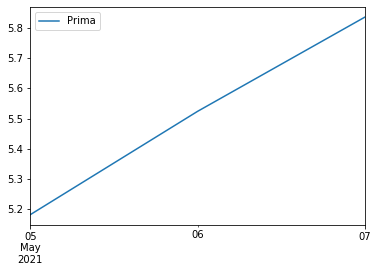

In [50]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [51]:
call.iloc[-1]

Prima    5.835541
Name: 2021-05-07 00:00:00, dtype: float64

### Intervarlos de confianza

In [52]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.714381104075803, 5.956701529726632)


In [53]:
opt_valuar['JSON']

{'contractSymbol': 'MCD210507C00230000',
 'strike': 230.0,
 'currency': 'USD',
 'lastPrice': 4.58,
 'change': 0.11000013,
 'percentChange': 2.460853,
 'volume': 50,
 'openInterest': 445,
 'bid': 4.85,
 'ask': 5.6,
 'contractSize': 'REGULAR',
 'expiration': 1620345600,
 'lastTradeDate': 1620235011,
 'impliedVolatility': 0.2651440673828125,
 'inTheMoney': True}

### 1.2 Histograma de rendimientos

In [57]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mc-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)


In [58]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

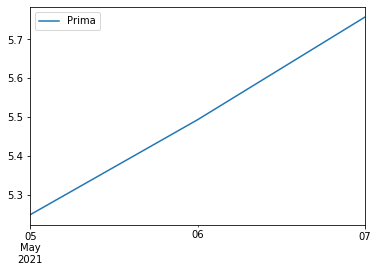

In [59]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [60]:
call_hist.iloc[-1]

Prima    5.757603
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [61]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.634705479118243, 5.880499746676507)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [62]:
opt_valuar['JSON']['lastPrice']

4.58

# 'CALL'- down-and-out

## VALUACIÓN DE UNA OPCION 'CALL'- down-and-out

### 3.1 Modelo normal de rendimientos

In [64]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = 0.006/360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666667e-05)

In [65]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

235.0399932861328

In [66]:
opt_valuar.Underlying_Price

235.04

In [84]:
pd.set_option('display.max_columns', 35)

B= 230

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod(axis=0)> 0
I


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-05-05,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True
2021-05-06,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True
2021-05-07,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,False


In [85]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(230.0, 235.04)

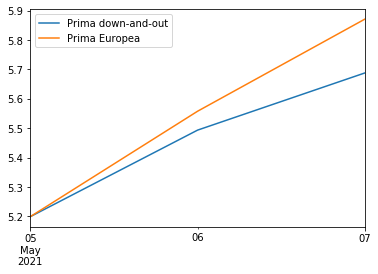

In [86]:
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [87]:
call.iloc[-1]

Prima Europea    5.871478
Name: 2021-05-07 00:00:00, dtype: float64

In [88]:
callui.iloc[-1]

Prima down-and-out    5.688329
Name: 2021-05-07 00:00:00, dtype: float64

#  'PUT'- Up-and-out

## VALUACIÓN DE UNA OPCION 'PUT'- Up-and-out

In [147]:
opt_deseada = mc_opt.loc[(mc_opt.Type=='put') & (mc_opt.Strike==240) & (mc_opt.Expiry=='2021-05-07')]
opt_deseada

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
429,240.0,2021-05-07,put,MCD210507P00240000,8.0,4.6,6.35,1.75,28.0,1.0,23.0,0.383307,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 14:42:42,"{'contractSymbol': 'MCD210507P00240000', 'stri..."


In [148]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            240
Expiry                                            2021-05-07 00:00:00
Type                                                              put
Symbol                                             MCD210507P00240000
Last                                                                8
                                          ...                        
Underlying                                                        MCD
Underlying_Price                                               235.04
Quote_Time                                        2021-05-05 20:00:02
Last_Trade_Date                                   2021-05-05 14:42:42
JSON                {'contractSymbol': 'MCD210507P00240000', 'stri...
Name: 429, Length: 19, dtype: object

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [149]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = (0.06/100) / 360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666665e-06)

In [150]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

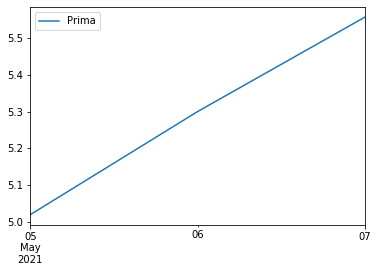

In [151]:
strike = K
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();

In [152]:
put.iloc[-1]

Prima    5.557368
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [153]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.43611620463181, 5.678620540401981)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [154]:
opt_valuar['JSON']['lastPrice']

8.0

### 1.2 Histograma de rendimientos

In [155]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mc-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)



In [156]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

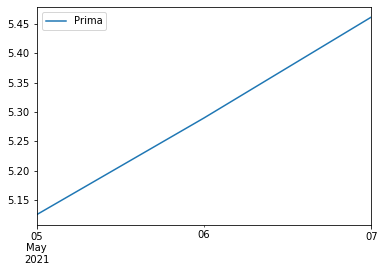

In [157]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [158]:
put_hist.iloc[-1]

Prima    5.461964
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [159]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.340990593340168, 5.5829379727935695)


In [160]:
opt_valuar['JSON']['lastPrice']

8.0

In [161]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

235.0399932861328

In [162]:
opt_valuar.Underlying_Price

235.04

In [163]:
pd.set_option('display.max_columns', 35)

B= 240

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0) > 0
I

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-05-05,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,...,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True
2021-05-06,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,...,False,True,False,True,True,True,True,True,True,True,False,False,True,False,True,True,True
2021-05-07,True,False,True,False,True,True,True,True,False,True,True,False,True,True,True,True,True,...,False,True,False,True,True,True,False,True,True,True,False,False,True,False,True,True,True


In [164]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(240.0, 235.04)

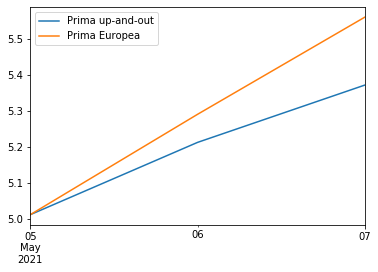

In [165]:
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes , 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

In [166]:
put.iloc[-1]

Prima Europea    5.561215
Name: 2021-05-07 00:00:00, dtype: float64

In [167]:
putui.iloc[-1]

Prima up-and-out    5.372725
Name: 2021-05-07 00:00:00, dtype: float64

## ANALISIS FINAL

# RESPUESTA JUAN PABLO

In [73]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

## Se descargan los precios del subyacente: `MSFT`

In [74]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [75]:
closes = get_adj_closes(['MSFT'],'2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

Date
2017-01-03     58.538
2017-01-04     58.276
2017-01-05     58.276
2017-01-06     58.782
2017-01-09     58.595
               ...   
2021-05-03    251.860
2021-05-04    247.790
2021-05-05    246.470
2021-05-06    249.730
2021-05-07    253.910
Name: MSFT, Length: 1094, dtype: float64

## Graficar los precios

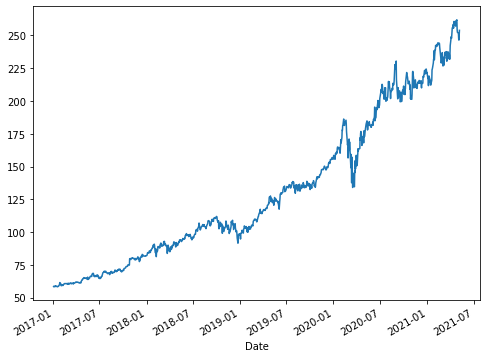

In [76]:
closes_msft.plot(figsize=[8,6]);

## Calcular los rendimientos

In [77]:
ret_msft = calc_daily_ret(closes_msft)

## Descargar datos de opciones para poder valuarlos

_Opciones de MSFT_

In [78]:
pd.set_option('display.max_rows',10)

msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index()

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2021-05-07,200.0,call,MSFT210507C00200000,...,2021-05-07 15:38:54,2021-05-05 19:00:24,"{'contractSymbol': 'MSFT210507C00200000', 'str..."
2021-05-07,155.0,put,MSFT210507P00155000,...,2021-05-07 15:38:54,2021-04-23 17:46:50,"{'contractSymbol': 'MSFT210507P00155000', 'str..."
2021-05-07,120.0,put,MSFT210507P00120000,...,2021-05-07 15:38:54,2021-05-03 13:30:01,"{'contractSymbol': 'MSFT210507P00120000', 'str..."
2021-05-07,120.0,call,MSFT210507C00120000,...,2021-05-07 15:38:54,2021-05-06 19:59:12,"{'contractSymbol': 'MSFT210507C00120000', 'str..."
2021-05-07,252.5,put,MSFT210507P00252500,...,2021-05-07 15:38:54,2021-05-07 15:23:05,"{'contractSymbol': 'MSFT210507P00252500', 'str..."
...,...,...,...,...,...,...,...
2023-06-16,285.0,call,MSFT230616C00285000,...,2021-05-07 15:38:57,2021-05-07 13:40:37,"{'contractSymbol': 'MSFT230616C00285000', 'str..."
2023-06-16,285.0,put,MSFT230616P00285000,...,2021-05-07 15:38:57,2021-04-29 19:07:08,"{'contractSymbol': 'MSFT230616P00285000', 'str..."
2023-06-16,290.0,call,MSFT230616C00290000,...,2021-05-07 15:38:57,2021-05-07 13:40:37,"{'contractSymbol': 'MSFT230616C00290000', 'str..."


>Elijo una fecha de vencimiento en particular.

In [79]:
fecha = '2021-09-17'
opt_call = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Expiry==fecha)]
opt_call

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
52,100.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-04-09 15:49:31,"{'contractSymbol': 'MSFT210917C00100000', 'str..."
64,105.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-04-09 16:45:11,"{'contractSymbol': 'MSFT210917C00105000', 'str..."
78,110.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-04-09 15:48:16,"{'contractSymbol': 'MSFT210917C00110000', 'str..."
99,115.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-02-26 20:01:59,"{'contractSymbol': 'MSFT210917C00115000', 'str..."
126,120.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-04-09 16:27:07,"{'contractSymbol': 'MSFT210917C00120000', 'str..."
...,...,...,...,...,...,...,...
1753,355.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-05-04 19:32:36,"{'contractSymbol': 'MSFT210917C00355000', 'str..."
1775,360.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-04-29 16:54:33,"{'contractSymbol': 'MSFT210917C00360000', 'str..."
1811,370.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-05-03 14:13:00,"{'contractSymbol': 'MSFT210917C00370000', 'str..."
1845,380.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-05-04 18:05:35,"{'contractSymbol': 'MSFT210917C00380000', 'str..."


## Sonrisa de volatilidad

>Utilizo la sonrisa de volatilidad para elegir mi precio de ejercicio 

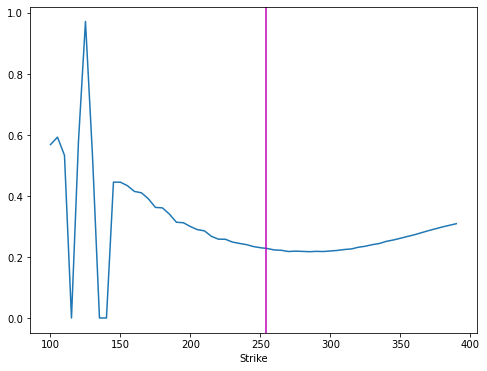

In [80]:
smile = opt_call.set_index('Strike').loc[:,'IV'].plot(figsize=[8,6])
smile.axvline(opt_call.Underlying_Price.iloc[0],color='m')

In [81]:
# valor actual del subyacente
print('El precio actual del activo es',opt_call.Underlying_Price.iloc[0])

El precio actual del activo es 253.89


In [82]:
# strike elegido
K = 255

In [83]:
opt_select = opt_call.loc[ (opt_call.Expiry==fecha) & (opt_call.Strike==K)]
opt_select

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1088,255.0,2021-09-17,call,...,2021-05-07 15:38:56,2021-05-07 15:05:38,"{'contractSymbol': 'MSFT210917C00255000', 'str..."


In [84]:
i_opt = opt_select.index
opcion = msft_opt.loc[i_opt[0]]
opcion['JSON']

{'contractSymbol': 'MSFT210917C00255000',
 'strike': 255.0,
 'currency': 'USD',
 'lastPrice': 13.08,
 'change': 1.8800001,
 'percentChange': 16.785715,
 'volume': 38,
 'openInterest': 3845,
 'bid': 13.05,
 'ask': 13.45,
 'contractSize': 'REGULAR',
 'expiration': 1631836800,
 'lastTradeDate': 1620399938,
 'impliedVolatility': 0.22769937347412106,
 'inTheMoney': False}

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

## Modelo normal de rendimientos

Tomo la tasa libre de riesgo de la pagina de la FED

 https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

In [85]:
np.random.seed(55)

In [86]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = (0.05/100)/360 
mu,sigma,r

(0.0013424492177613095, 0.01797674307976112, 1.388888888888889e-06)

## Simulación de precios

In [87]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

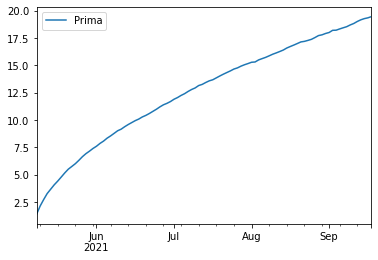

In [88]:
strike = K
call_r=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call_r.plot();

In [89]:
call_r.iloc[-1] # valuación europea

Prima    19.45
Name: 2021-09-17 00:00:00, dtype: float64

In [90]:
opcion['JSON']['lastPrice'] # last price

13.08

## Intervalos de confianza

In [91]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call_r.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(18.551766537421074, 20.348600187359423)


## Histograma de rendimientos

In [92]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [93]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

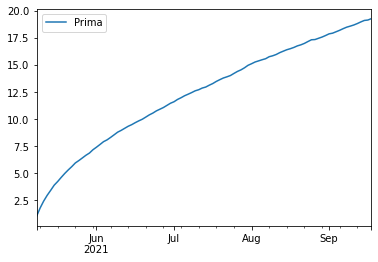

In [94]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [95]:
call_hist.iloc[-1] # valuación europea

Prima    19.265
Name: 2021-09-17 00:00:00, dtype: float64

## Intervalos de confianza

In [96]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(18.37608608364095, 20.15406831528584)


In [97]:
opcion['JSON']['lastPrice'] # valuación

13.08

## Valuación de una opción call down and out

>Como es un down la barrera debe estar abajo del spot price


In [98]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 240

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-07,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-10,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-11,True,True,False,True,True,True,True,...,True,True,True,True,False,True,True
2021-05-12,True,True,False,True,True,True,True,...,True,True,True,True,False,True,True
2021-05-13,True,True,False,True,True,True,True,...,True,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False
2021-09-14,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False
2021-09-15,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False
2021-09-16,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False


## Valuación con rendimientos normales

In [99]:
K = opcion.Strike
S0 = opcion.Underlying_Price
K,S0

(255.0, 253.89)

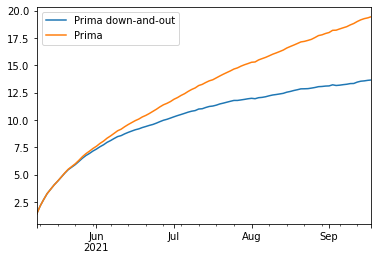

In [100]:

# Calcular la prima de una opción barrera
callui_r = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui_r.plot();
call_r.plot(ax=ax);

In [101]:
call_r.iloc[-1] # valuación europea

Prima    19.45
Name: 2021-09-17 00:00:00, dtype: float64

In [102]:
callui_r.iloc[-1] # valuación down and out

Prima down-and-out    13.656
Name: 2021-09-17 00:00:00, dtype: float64

In [103]:
opcion['JSON']['lastPrice'] # last price

13.08

## Intervalo de confianza

In [104]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = callui_r.iloc[-1]['Prima down-and-out']

i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(12.75765376296377, 14.55448741290212)


## Valuación con el método del histograma

In [105]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [106]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [107]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 240

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes_hist > B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-07,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-10,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-11,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-12,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-13,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13,True,True,False,True,False,False,False,...,True,True,True,False,True,True,False
2021-09-14,True,True,False,True,False,False,False,...,True,True,True,False,True,True,False
2021-09-15,True,True,False,True,False,False,False,...,True,True,True,False,True,True,False
2021-09-16,True,True,False,True,False,False,False,...,True,True,False,False,True,True,False


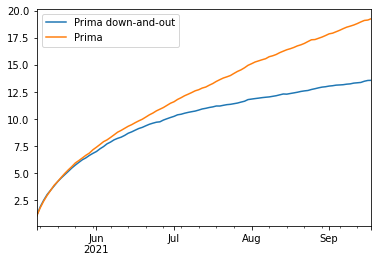

In [108]:

# Calcular la prima de una opción barrera
callui_hist = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes_hist-strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui_hist.plot();
call_hist.plot(ax=ax);

In [109]:
callui_hist.iloc[-1] # valuación down and out

Prima down-and-out    13.576
Name: 2021-09-17 00:00:00, dtype: float64

In [110]:
call_hist.iloc[-1] # valuación europea

Prima    19.265
Name: 2021-09-17 00:00:00, dtype: float64

In [111]:
opcion['JSON']['lastPrice'] # last price

13.08

## Intervalos de confianza

In [112]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = callui_hist.iloc[-1]['Prima down-and-out']

i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(12.694124072275997, 14.456927815342045)


## Valuación de una put como una Europea

In [113]:
opt_put = msft_opt.loc[(msft_opt.Type=='put') & (msft_opt.Expiry==fecha)]
opt_put


,Strike,Expiry,Type,Symbol,Last,Bid,Ask,...,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
53,100.0,2021-09-17,put,MSFT210917P00100000,0.16,0.14,0.16,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-05-03 15:19:53,"{'contractSymbol': 'MSFT210917P00100000', 'str..."
65,105.0,2021-09-17,put,MSFT210917P00105000,0.23,0.17,0.19,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-05-04 18:46:11,"{'contractSymbol': 'MSFT210917P00105000', 'str..."
79,110.0,2021-09-17,put,MSFT210917P00110000,0.25,0.19,0.22,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-04-28 13:41:31,"{'contractSymbol': 'MSFT210917P00110000', 'str..."
100,115.0,2021-09-17,put,MSFT210917P00115000,0.30,0.23,0.25,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-04-29 16:34:18,"{'contractSymbol': 'MSFT210917P00115000', 'str..."
127,120.0,2021-09-17,put,MSFT210917P00120000,0.28,0.26,0.28,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-05-03 14:10:19,"{'contractSymbol': 'MSFT210917P00120000', 'str..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,340.0,2021-09-17,put,MSFT210917P00340000,85.70,86.70,87.35,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-04-09 19:38:07,"{'contractSymbol': 'MSFT210917P00340000', 'str..."
1709,345.0,2021-09-17,put,MSFT210917P00345000,115.20,108.25,109.95,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-02-24 14:39:00,"{'contractSymbol': 'MSFT210917P00345000', 'str..."
1733,350.0,2021-09-17,put,MSFT210917P00350000,94.75,96.60,97.25,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-04-28 13:32:49,"{'contractSymbol': 'MSFT210917P00350000', 'str..."
1776,360.0,2021-09-17,put,MSFT210917P00360000,112.35,108.80,113.50,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-04-06 17:31:55,"{'contractSymbol': 'MSFT210917P00360000', 'str..."


## Sonrisa de volatilidad

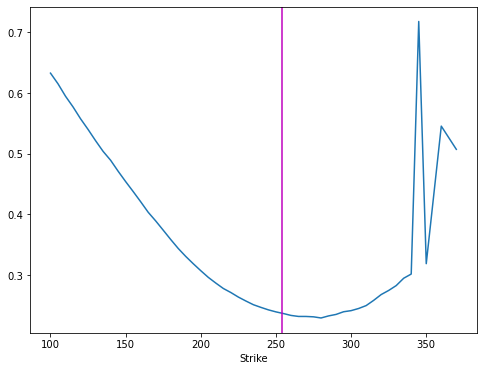

In [114]:
smile = opt_put.set_index('Strike').loc[:,'IV'].plot(figsize=[8,6])
smile.axvline(opt_put.Underlying_Price.iloc[0],color='m')

In [115]:
#strike elegido
K = 230

In [116]:
opt = opt_put.loc[(opt_put.Strike==K) & (opt_put.Expiry==fecha)]
opt

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,...,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
850,230.0,2021-09-17,put,MSFT210917P00230000,5.99,5.75,6.0,...,MSFT,False,MSFT,253.89,2021-05-07 15:38:56,2021-05-07 15:05:38,"{'contractSymbol': 'MSFT210917P00230000', 'str..."


In [117]:
i_opt = opt.index
opcion = msft_opt.loc[i_opt[0]]
opcion['JSON']

{'contractSymbol': 'MSFT210917P00230000',
 'strike': 230.0,
 'currency': 'USD',
 'lastPrice': 5.99,
 'change': -1.4100003,
 'percentChange': -19.054058,
 'volume': 131,
 'openInterest': 5127,
 'bid': 5.75,
 'ask': 6.0,
 'contractSize': 'REGULAR',
 'expiration': 1631836800,
 'lastTradeDate': 1620399938,
 'impliedVolatility': 0.2573316455078125,
 'inTheMoney': False}

## Modelo normal de rendimientos

In [118]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

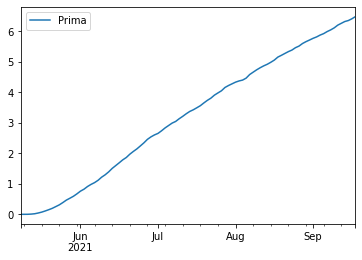

In [119]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_r=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_r.plot();

In [120]:
put_r.iloc[-1] # valuación europea

Prima    6.474
Name: 2021-09-17 00:00:00, dtype: float64

In [121]:
opcion['JSON']['lastPrice'] # last price

5.99

## Intervalos de confianza

In [122]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put_r.iloc[-1].Prima

i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.577860694199478, 7.369196929867943)


## Histograma de rendimientos

In [123]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [124]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

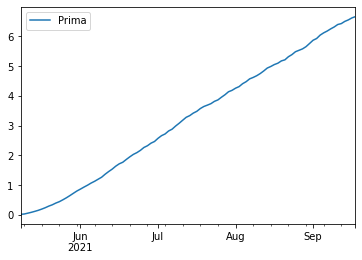

In [125]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [126]:
put_hist.iloc[-1] # valuación europea

Prima    6.659
Name: 2021-09-17 00:00:00, dtype: float64

In [127]:
opcion['JSON']['lastPrice'] # last prcie

5.99

## Intervalos de confianza

In [128]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.762414689767505, 7.556566870678765)


## Valuación de una put como una barrera up and out

> Como es un up la barrera debe estar por encima del spot price

In [129]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 260

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-07,False,True,True,False,True,True,True,...,False,True,True,False,False,True,False
2021-05-10,False,True,True,False,True,True,True,...,False,True,True,False,False,True,False
2021-05-11,False,True,False,False,True,True,True,...,False,True,True,False,False,True,False
2021-05-12,False,True,False,False,True,True,True,...,False,True,False,False,False,True,False
2021-05-13,False,False,False,False,True,True,True,...,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False
2021-09-14,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False
2021-09-15,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False
2021-09-16,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False


## Valuación con rendimientos normales

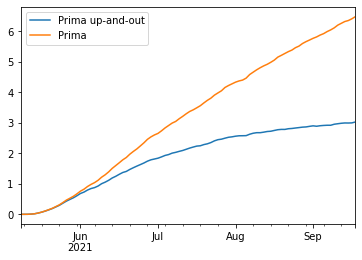

In [130]:

# Calcular la prima de una opción barrera
putui_r = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui_r.plot();
put_r.plot(ax=ax);

In [131]:
putui_r.iloc[-1] # valuación up and out

Prima up-and-out    3.024
Name: 2021-09-17 00:00:00, dtype: float64

In [132]:
put_r.iloc[-1] # valuación europea

Prima    6.474
Name: 2021-09-17 00:00:00, dtype: float64

In [133]:
opcion['JSON']['lastPrice'] #last price

5.99

## Intervalos de confianza

In [134]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = putui_r.iloc[-1]['Prima up-and-out']

i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(2.1279184237069835, 3.91925465937545)


## Valuación con el histograma

In [135]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [136]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [137]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 260

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes_hist < B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-07,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-10,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-11,False,True,False,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-12,False,True,False,True,True,True,False,...,True,True,True,True,True,True,True
2021-05-13,False,True,False,True,True,True,False,...,False,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13,False,True,False,True,True,True,False,...,False,True,False,False,True,False,False
2021-09-14,False,True,False,True,True,True,False,...,False,True,False,False,True,False,False
2021-09-15,False,True,False,True,True,True,False,...,False,True,False,False,True,False,False
2021-09-16,False,True,False,True,True,True,False,...,False,True,False,False,True,False,False


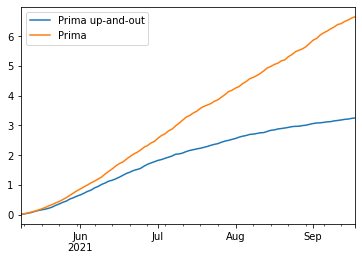

In [138]:

# Calcular la prima de una opción barrera
putui_hist = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes_hist, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui_hist.plot();
put_hist.plot(ax=ax);

In [139]:
putui_hist.iloc[-1]

Prima up-and-out    3.253
Name: 2021-09-17 00:00:00, dtype: float64

In [140]:
put_hist.iloc[-1]

Prima    6.659
Name: 2021-09-17 00:00:00, dtype: float64

In [141]:
opcion['JSON']['lastPrice']

5.99

## Intervalos de confianza

In [142]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = putui_hist.iloc[-1]['Prima up-and-out']

i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(2.3590479083077858, 4.147017225818953)


## Resultados

In [177]:
results = pd.DataFrame(columns=['histogram','rend_norm','lastprice_put','lastprice_call'],
                      index=['call_europea','call_down_out','put_europea','put_up_in'])
h = [call_hist,callui_hist,put_hist,putui_hist]
r = [call_r,callui_r,put_r,putui_r]
results['histogram']=np.array([i.iloc[-1].values for i in h])
results['rend_norm']=np.array([i.iloc[-1].values for i in r])
results['lastprice_put']=5.99
results['lastprice_call']=13.08
results.T

,call_europea,call_down_out,put_europea,put_up_in
histogram,19.265,13.576,6.659,3.253
rend_norm,19.450,13.656,6.474,3.024
lastprice_put,5.990,5.990,5.990,5.990
lastprice_call,13.080,13.080,13.080,13.080


## Análisis

Comenzando por la valuación de las europeas se observa cierto grado de error entre el último precio al que cotizaron y el valor aproximado, sin embargo, la valuación por el método del histograma resulta más precisos en ambos casos.

En cuanto a la valuación del **call down and out** se logro obtener una valoración menor a la del call europeo el cual fue de como se pude observar en la tabla de resultados, la  En este caso se estableció una barrera en 260, mientrás que el spot price es de 249.51 y el strike price de k =230 (utilizando la sonrisa de volatilidad para definirlo). Esto nos podría dar el derecho a vender (siempre y cuando no toquemos la barrera) a $S_t=260$ esperando que el precio del activo pueda bajar ya que desde una perspectiva fundamentalista esta sobrevalorado y ante el riesgo de alsas en la tasa de interés los activos de alto rendimiento como el nuestro podrían sufir una correción a la baja.

Referente a la valuación call down and out se logro obtener una menor valuación $down/out = 7.328$ por el método del historgama y de $down/out = 6.652$ por el método de los rendimientos normales en contraste a la europea. Se estableció una barrera en $S_t=240$, pensando en que nuestro activo pueda continuar apreciandose mientrás las tasas de interés sigan bajas y la tendencia bullish del mercado continue defino un strike price $k =255$ (utilizando la sonrisa de volatilidad para definirlo).

En conclusión las opciones barrera ofrecen una gran alternativa a las europeas ya que salimos beneficiados en cuestión de costos, no obstante, se debe definir muy bien la estrategia a utilizar ya que en donde decidamos ubicar la barrera resultara fundamental para poder ejercer nuestra opción por lo que un estudio detallado del comportamiento del subyacente se debería realizar previamente. 

Finalmente con respecto a los métodos de aproximación me llamo la atención que para las opciones europeas asumir el método de rendimientos normales obtuvo mejores aproximaciones, mientrás que por el otro lado, las aproximaciones de las opciones barreras u _opciones_ exoticas tuvieron mejores aproximaciones con el método del histograma. En el caso de las europeas esto podría deberse a que en el método de rendimientos normales utilizamos la solución a la ecuación de B&S, ecuación que ofrece una solución cerrada para opciones europeas. En el caso de las opciones barrera al ser _exoticas_ y no tener una solución cerrada como B&S se utilizan otros metodos numericos para aproximar su valor como en este caso el del hsitograma.
